<a href="https://colab.research.google.com/github/frnocentini/a-star-js/blob/master/Brain_tumor_effnet_crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/dataset brain tumor/dataset'


/content/drive/MyDrive/dataset brain tumor/dataset


In [ ]:
!unzip 'axial_t1wce_2_class' -d '/dataset unzipped'

Archive:  axial_t1wce_2_class.zip
  inflating: /dataset unzipped/axial_t1wce_2_class/axial_t1wce_2_class.yaml  
   creating: /dataset unzipped/axial_t1wce_2_class/images/
   creating: /dataset unzipped/axial_t1wce_2_class/images/test/
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_101.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_109.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_111.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_117.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_121.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_126.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_134.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00019_66.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00019_75.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/image

In [ ]:
!unzip 'coronal_t1wce_2_class' -d '/dataset unzipped'

Archive:  coronal_t1wce_2_class.zip
  inflating: /dataset unzipped/coronal_t1wce_2_class/coronal_t1wce_2_class.yaml  
   creating: /dataset unzipped/coronal_t1wce_2_class/images/
   creating: /dataset unzipped/coronal_t1wce_2_class/images/test/
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/13.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/15.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/17.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/19.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/20.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/23.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/33.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/34.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/35.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/36.jpg  
  inflating: /d

In [ ]:
!unzip 'sagittal_t1wce_2_class' -d '/dataset unzipped'

Archive:  sagittal_t1wce_2_class.zip
   creating: /dataset unzipped/sagittal_t1wce_2_class/images/
   creating: /dataset unzipped/sagittal_t1wce_2_class/images/test/
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00000_102.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00000_121.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00000_140.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00000_159.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00002_110.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00002_129.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00002_147.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00002_166.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00003_154.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00003_173.jpg  
  inflating: /

In [ ]:
# Data Manipulation
import numpy as np
import pandas as pd
import os
# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense, Activation
from PIL import Image
# Other
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import imutils

In [ ]:
%cd '/dataset unzipped'

/dataset unzipped


In [ ]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightl
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]
    #thresh = cv2.erode(thresh, None, iterations=2)
    #thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image,extLeft,extRight,extTop,extBot

In [ ]:
#Bounding box with one tumor
lab = ['axial_t1wce_2_class','coronal_t1wce_2_class', 'sagittal_t1wce_2_class']
X_train = []
bb = []
count = 0;
temp_array  = []
extLeft_coords_x = []
extLeft_coords_y = []
extRight_coords_x = []
extRight_coords_y = []
extTop_coords_x = []
extTop_coords_y = []
extBot_coords_x = []
extBot_coords_y = []
image_width = []
image_height = []


extLeft_coords_x_test = []
extLeft_coords_y_test = []
extRight_coords_x_test = []
extRight_coords_y_test = []
extTop_coords_x_test = []
extTop_coords_y_test = []
extBot_coords_x_test = []
extBot_coords_y_test = []
images_width_test = []
images_height_test = []
width_new_im = []
height_new_im = []
traslazione_x_test = []
traslazione_y_test = []

image_size = 180

for i in lab:
    folderPath = os.path.join('./',i,'images','train')
    for j in sorted(os.listdir(folderPath)):
        #load the image
        img = cv2.imread(os.path.join(folderPath,j))
        image_width.append(img.shape[1])
        image_height.append(img.shape[0])
        # crop the brain and ignore the unnecessary rest part of the image
        image,extLeft,extRight,extTop,extBot = crop_brain_contour(img,False)
        extLeft_coords_x.append(extLeft[0])
        extLeft_coords_y.append(extLeft[1])
        extRight_coords_x.append(extRight[0])
        extRight_coords_y.append(extRight[1])
        extTop_coords_x.append(extTop[0])
        extTop_coords_y.append(extTop[1])
        extBot_coords_x.append(extBot[0])
        extBot_coords_y.append(extBot[1])
        # resize image
        image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
        #if img.shape[0] != img.shape[1]:
            #img = make_square(img, fill_color=(0, 0, 0, 0))
        #img = cv2.resize(img,(image_size, image_size))
        X_train.append(image)

image_index = 0
#bb_train = np.zeros((len(X_train),4))
bb_list = []
duplicate_img = []
for i in lab:
    labelsPath = os.path.join('./',i,'labels','train')
    for j in sorted(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            lbls_array = []
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    temp_array.append(k)
                temp_array.pop(0)
                 
                temp_array[0] = temp_array[0]*image_width[count] #centro x immagine originale
                temp_array[0] = temp_array[0]-extLeft_coords_x[count]
                temp_array[0] = (temp_array[0]/(extRight_coords_x[count]-extLeft_coords_x[count]))*image_size
                
                temp_array[1] = temp_array[1]*image_height[count]
                temp_array[1] = temp_array[1]-extTop_coords_y[count]
                temp_array[1] = (temp_array[1]/(extBot_coords_y[count]-extTop_coords_y[count]))*image_size
                
                temp_array[2] = temp_array[2]*(image_width[count])
                temp_array[2] = (temp_array[2]/(extRight_coords_x[count]-extLeft_coords_x[count]))*image_size
                
                
                temp_array[3] = temp_array[3]*(image_height[count])
                temp_array[3] = (temp_array[3]/(extBot_coords_y[count]-extTop_coords_y[count]))*image_size                 
            
                lbls_array.append(temp_array)

                #print(temp_array)
                #bb_train[image_index] = np.array([temp_array])
                #print(bb_train[image_index])

            bb_list.append(temp_array)
            duplicate_img.append(lbls_array)
            image_index += 1
            count += 1

#Codice per duplicare le immagini con due bounding box
print('Dimensione delle liste prima di duplicare le immagini:')
print('X_train: ', len(X_train))
print('bb_list: ', len(bb_list))

for i in range(len(X_train)):
  if(len(duplicate_img[i]) == 2):
    X_train.append(X_train[i])
    bb_list.append(duplicate_img[i][0])  #dentro bb_list è già stata inserita la seconda label, quindi ora insieriamo la prima per l'immagine duplicata
bb_train = np.zeros((len(X_train),4))

for j in range(len(bb_list)):
  bb_train[j] = np.array([bb_list[j]])

#Dimensione delle liste dopo la duplicazione delle immagini:
print('Dimensione delle liste dopo la duplicazione delle immagini:')
print('X_train: ', len(X_train))
print('bb_train: ', len(bb_train))

X_test = []
for i in lab:
    folderPath = os.path.join('./',i,'images','test')
    for j in sorted(os.listdir(folderPath)):
        #load the image
        img = cv2.imread(os.path.join(folderPath,j))
        images_width_test.append(img.shape[1])
        images_height_test.append(img.shape[0])
        # crop the brain and ignore the unnecessary rest part of the image
        image_test,extLeft_test,extRight_test,extTop_test,extBot_test = crop_brain_contour(img,False)
        extLeft_coords_x_test.append(extLeft_test[0])
        extLeft_coords_y_test.append(extLeft_test[1])
        extRight_coords_x_test.append(extRight_test[0])
        extRight_coords_y_test.append(extRight_test[1])
        extTop_coords_x_test.append(extTop_test[0])
        extTop_coords_y_test.append(extTop_test[1])
        extBot_coords_x_test.append(extBot_test[0])
        extBot_coords_y_test.append(extBot_test[1])
        # resize image
        image_test = cv2.resize(image_test, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
        #if img.shape[0] != img.shape[1]:
            #img = make_square(img, fill_color=(0, 0, 0, 0))
        #img = cv2.resize(img,(image_size, image_size))
        X_test.append(image_test)

image_index = 0
count_test = 0;
#bb_test = np.zeros((len(X_test),4))
bb_list = []
duplicate_img = []
for i in lab:
    labelsPath = os.path.join('./',i,'labels','test')
    for j in sorted(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            lbls_array = []
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    temp_array.append(k)
                temp_array.pop(0)
                #width_new_im.append(extRight_coords_x_test[count_test]-extLeft_coords_x_test[count_test])
                #height_new_im.append(extBot_coords_y_test[count_test]-extTop_coords_y_test[count_test])
                
                
                temp_array[0] = temp_array[0]*images_width_test[count_test] #centro x immagine originale
                temp_array[0] = temp_array[0]-extLeft_coords_x_test[count_test]
                temp_array[0] = (temp_array[0]/(extRight_coords_x_test[count_test]-extLeft_coords_x_test[count_test]))*image_size
                
                temp_array[1] = temp_array[1]*images_height_test[count_test]
                temp_array[1] = temp_array[1]-extTop_coords_y_test[count_test]
                temp_array[1] = (temp_array[1]/(extBot_coords_y_test[count_test]-extTop_coords_y_test[count_test]))*image_size
                
                temp_array[2] = temp_array[2]*(images_width_test[count_test])
                temp_array[2] = (temp_array[2]/(extRight_coords_x_test[count_test]-extLeft_coords_x_test[count_test]))*image_size
                
                
                temp_array[3] = temp_array[3]*(images_height_test[count_test])
                temp_array[3] = (temp_array[3]/(extBot_coords_y_test[count_test]-extTop_coords_y_test[count_test]))*image_size                 
            
                lbls_array.append(temp_array)

                #bb_test[image_index] = np.array([temp_array])
                #print(bb_test[image_index])

            bb_list.append(temp_array)
            duplicate_img.append(lbls_array)
            image_index += 1
            count_test += 1

#Codice per duplicare le immagini con due bounding box
print('Dimensione delle liste prima di duplicare le immagini:')
print('X_test: ', len(X_test))
print('bb_list: ', len(bb_list))

for i in range(len(X_test)):
  if(len(duplicate_img[i]) == 2):
    X_test.append(X_test[i])
    bb_list.append(duplicate_img[i][0])  #dentro bb_list è già stata inserita la seconda label, quindi ora insieriamo la prima per l'immagine duplicata

bb_test = np.zeros((len(X_test),4))

for j in range(len(bb_test)):
  bb_test[j] = np.array([bb_list[j]])

#Dimensione delle liste dopo la duplicazione delle immagini:
print('Dimensione delle liste dopo la duplicazione delle immagini:')
print('X_test: ', len(X_test))
print('bb_test: ', len(bb_test))

#print(bb_test[30])
#print(extRight_coords_x_test[30])
#print(extLeft_coords_x_test[30])

Dimensione delle liste prima di duplicare le immagini:
X_train:  878
bb_list:  878
Dimensione delle liste dopo la duplicazione delle immagini:
X_train:  919
bb_train:  919
Dimensione delle liste prima di duplicare le immagini:
X_test:  223
bb_list:  223
Dimensione delle liste dopo la duplicazione delle immagini:
X_test:  237
bb_test:  237


In [ ]:
len(X_train)

919

In [ ]:
#prepare dataset 
train_dataset = ImageDataGenerator()
val_dataset = ImageDataGenerator()
test_dataset = ImageDataGenerator()

In [ ]:
#array conversion
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
#Shuffle
X_train, bb_train = shuffle(X_train, bb_train)

In [ ]:
#Validation set created
X_train, X_val, bb_train, bb_val = train_test_split(X_train, bb_train, test_size = 0.1, shuffle = False)

In [ ]:
BATCH_SIZE = 16
#save_path = os.path.join('./', 'model_effnet')
train_dataset = train_dataset.flow(X_train, bb_train, batch_size = BATCH_SIZE)
val_dataset = val_dataset.flow(X_val, bb_val, batch_size = BATCH_SIZE)
test_dataset = test_dataset.flow(X_test, bb_test, batch_size = BATCH_SIZE)

In [ ]:
METRIC_THRESH = 0.3

def raw_iou(y_true, y_pred):
    results = []
    for i in range(0,y_true.shape[0]):


        boxTrue_width = y_true[i,2]
        boxTrue_height = y_true[i,3]
        x_boxTrue_tleft = y_true[i,0]-boxTrue_width/2  # numpy index selection
        y_boxTrue_tleft = y_true[i,1]-boxTrue_height/2
    
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        boxPred_width = y_pred[i,2]
        boxPred_height = y_pred[i,3]
        x_boxPred_tleft = y_pred[i,0]-boxPred_width/2  
        y_boxPred_tleft = y_pred[i,1]-boxPred_height/2
    
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = np.mean(area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)).astype(np.float32)


        # This must match the type used in py_func
        results.append(iou)
    return np.mean(results)

def IoU(y_true, y_pred):
    iou = tf.numpy_function(raw_iou, [y_true, y_pred], tf.float32)
    return iou



In [ ]:
#def iou(y_true,y_pred):
  #pred_bbox_val = model.predict(X_val)
  #iou = tf.numpy_function(calculate_iou,[y_true,y_pred],tf.float32)
  #return iou

In [ ]:
# Draw the predicted bounding boxes
def display_image(img, bbox_coords, pred_coords):
    if len(bbox_coords) == 4: #in rosso
        xmin, ymin, width, height = bbox_coords
        img = cv2.rectangle(img, (int(xmin-width/2), int(ymin-height/2)), (int(xmin+width/2), int(ymin+height/2)), (255, 0, 0), 1)
        #img = cv2.rectangle(img, (0,0),(10,10), (0, 0, 255), 1)
    if len(pred_coords) == 4: #in verde
        xmin1, ymin1, width1, height1 = pred_coords
        img = cv2.rectangle(img, (int(xmin1-width1/2), int(ymin1-height1/2)), (int(xmin1+width1/2), int(ymin1+height1/2)), (0, 255, 0), 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
#To test the model
def test_model(model):
    rand_index = np.random.randint(0, bb_test.shape[0])
    pred_bbox = model.predict(X_test)[rand_index]
    img_original = X_test[rand_index]
    img = img_original.copy()
    coords = bb_test[rand_index]
    #example, label = next(datagen)
    #X = example['image']
    #y = label['coords']
    #pred_bbox = model.predict(X)[0]
    #img = X[0]
    #gt_coords = y[0]
    
    display_image(img,bbox_coords = coords, pred_coords=pred_bbox)

def test(model):
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model)    
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)
        

In [ ]:
%cd '../content/drive/MyDrive'
! mkdir  model_checkpoint_SCRATCH

save_path = './model_checkpoint_EFFNET/model_EFFNET.h5'
     

/content/drive/MyDrive
mkdir: cannot create directory ‘model_checkpoint_SCRATCH’: File exists


In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    include_optimizer=False,
    save_format = 'h5',
    filepath=save_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
    ),
    ShowTestImages()
]

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(4,name='bb_pred')(model)
model = tf.keras.models.Model(inputs=effnet.inputs, outputs = model)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
def get_config(self):
    config = super().get_config()
    return config

In [ ]:
model.compile(
    loss={
        'bb_pred': 'mae'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[IoU]
    
)

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 29.3768 - IoU: 0.0449
Epoch 1: val_loss did not improve from 41.11656
8/8 [==============================] - 0s 37ms/step


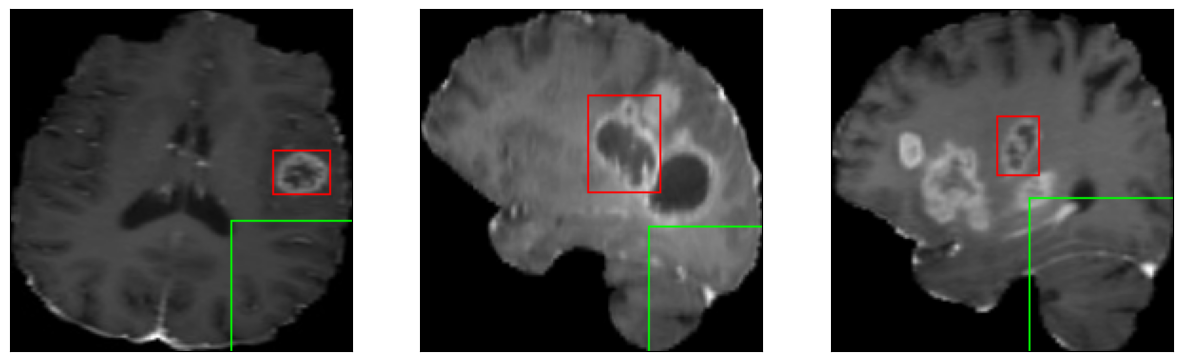

52/52 [==============================] - 52s 239ms/step - loss: 29.3768 - IoU: 0.0449 - val_loss: 90.1155 - val_IoU: 0.0049
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 20.8594 - IoU: 0.1026
Epoch 2: val_loss did not improve from 41.11656
8/8 [==============================] - 0s 37ms/step


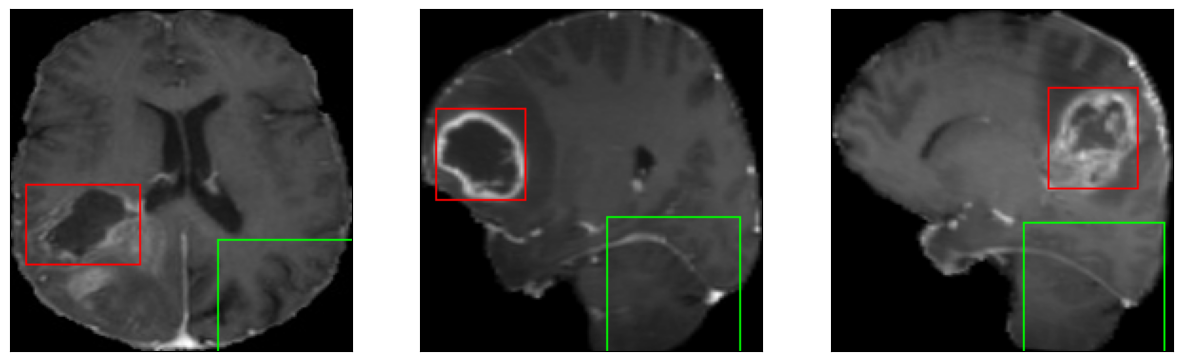

52/52 [==============================] - 7s 135ms/step - loss: 20.8594 - IoU: 0.1026 - val_loss: 54.2544 - val_IoU: 0.0027
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 17.8296 - IoU: 0.1295
Epoch 3: val_loss improved from 41.11656 to 22.34102, saving model to ./model_checkpoint_EFFNET/model_EFFNET.h5


TypeError: ignored

In [ ]:
model.fit(
        train_dataset,
        epochs=100,
        validation_data = val_dataset,
        callbacks = callbacks_list
        )

In [ ]:
# Draw the predicted bounding boxes
def display_image(img, bbox_coords, pred_coords):
    if len(bbox_coords) == 4: #in rosso
        xmin, ymin, height, width = bbox_coords
        img = cv2.rectangle(img, (int(xmin-height/2), int(ymin-width/2)), (int(xmin+height/2), int(ymin+width/2)), (255, 0, 0), 1)
        
    if len(pred_coords) == 4: #in verde
        xmin1, ymin1, height1, width1 = pred_coords
        img = cv2.rectangle(img, (int(xmin1-height1/2), int(ymin1-width1/2)), (int(xmin1+height1/2), int(ymin1+width1/2)), (0, 255, 0), 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])


In [ ]:
#iou = IoU(y_true, y_pred, 4, [1])
model = tf.keras.models.load_model('./model_checkpoint_SCRATCH/model_SCRATCH.h5',compile = False)

In [ ]:
model.compile(
    loss={
        'coords': 'mae'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[IoU]
)

In [ ]:
model.evaluate(test_dataset)